<a href="https://colab.research.google.com/github/khykelly-cloud/mul/blob/main/%EC%A2%80%ED%95%9C%EB%B2%84%EC%A0%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install ortools


In [7]:
pip install pyscipopt


In [8]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2



고객 수: 50 / 물류센터 후보지 수: 5 / 트럭 적재용량: 160

[입지선정 결과 - DistributionCenter 기반]
선정된 DC 인덱스 (DistributionCenter.csv 기준): [2, 3]
p-median 최소비용(참고용): 1020.8514091638983

[DC별 고객 배정 결과]
DC 2 → 고객 수 33명
DC 3 → 고객 수 17명

[DC별 VRP 결과]

=== DC 2 기준 VRP ===
DC 총 비용: 323
경로 수: 4

=== DC 3 기준 VRP ===
DC 총 비용: 170
경로 수: 2

전체 DC + VRP 총 비용: 493


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr

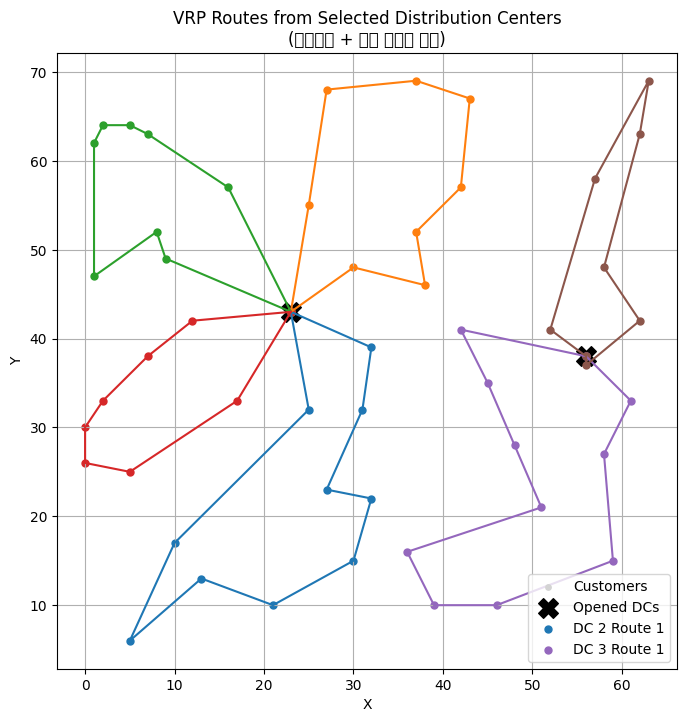

In [9]:
# ============================================================
# 0. 라이브러리 임포트
# ============================================================
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from itertools import combinations
from math import sqrt, ceil
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
import matplotlib.pyplot as plt

# ============================================================
# 1. 데이터 불러오기
# ============================================================
cust = pd.read_csv("Customer.csv")
truck_df = pd.read_csv("Truck.csv")
dc = pd.read_csv("DistributionCenter.csv")

cust_xy = cust[["X", "Y"]].values              # 고객 좌표 (N x 2)
dc_xy = dc[["X", "Y"]].values                  # 물류센터 후보 좌표 (M x 2)
demands = cust["DEMAND"].astype(int).values    # 고객 수요
truck_capacity = int(truck_df.loc[0, "CAPACITY"])

N = len(cust_xy)
M = len(dc_xy)
print("고객 수:", N, "/ 물류센터 후보지 수:", M, "/ 트럭 적재용량:", truck_capacity)

# ============================================================
# 2. 서울형 혼잡 패널티 함수 (좌표 범위는 예시이므로 필요하면 조정)
# ============================================================
def get_penalty(x, y):
    # 최상 혼잡: 도심(종로/중구/강남역) 예시
    if 450 <= x <= 520 and 800 <= y <= 860:
        return 1.8
    if 200 <= x <= 260 and 400 <= y <= 460:
        return 1.8
    # 중간 혼잡: 서부간선도로 예시
    if 100 <= x <= 200 and 300 <= y <= 450:
        return 1.3
    # 준혼잡: 홍대/성수 등 상권 예시
    if 300 <= x <= 380 and 650 <= y <= 720:
        return 1.2
    # 기본
    return 1.0

# 고객 ↔ DC 거리행렬 + 고객 위치 기준 패널티 적용 (N x M)
base_dist_cust_dc = cdist(cust_xy, dc_xy, metric="euclidean")
penalty_cust = np.array([get_penalty(x, y) for x, y in cust_xy])  # N
dist_pen_cust_dc = base_dist_cust_dc * penalty_cust[:, None]

# ============================================================
# 3. p-Median : DC 후보지 중 p개 선택
#    (고객 ↔ DC 비용을 최소화하는 후보 조합 찾기)
# ============================================================
def p_median_dc(p):
    best_cost = 1e18
    best_combo = None

    for combo in combinations(range(M), p):  # DC 후보지 index 조합
        combo = list(combo)
        # 각 고객이 combo 중 가장 가까운 DC에 간다고 가정
        cost = np.min(dist_pen_cust_dc[:, combo], axis=1).sum()
        if cost < best_cost:
            best_cost = cost
            best_combo = combo

    return best_combo, best_cost

p = 2   # 설치할 물류센터 개수 (원하면 1~5 중 바꿔보기)
open_dcs, pm_cost = p_median_dc(p)

print("\n[입지선정 결과 - DistributionCenter 기반]")
print("선정된 DC 인덱스 (DistributionCenter.csv 기준):", open_dcs)
print("p-median 최소비용(참고용):", pm_cost)

# ============================================================
# 4. 고객 → 선택된 DC로 배정
# ============================================================
assignments = [[] for _ in range(p)]  # DC별 고객 리스트

for i in range(N):
    dists = [dist_pen_cust_dc[i, j] for j in open_dcs]
    nearest = int(np.argmin(dists))
    assignments[nearest].append(i)

print("\n[DC별 고객 배정 결과]")
for idx, group in enumerate(assignments):
    print(f"DC {open_dcs[idx]} → 고객 수 {len(group)}명")

# ============================================================
# 5. 각 DC 기준 VRP (센터 좌표 = DistributionCenter.csv)
# ============================================================
def solve_vrp_for_dc(dc_index, cust_indices, truck_capacity):

    # 0번 노드 = depot(해당 DC 위치)
    depot_coord = dc_xy[dc_index]
    cust_coords = cust_xy[cust_indices]

    local_coords = np.vstack([depot_coord, cust_coords])
    local_demands = np.array([0] + list(demands[cust_indices]), dtype=int)

    num_nodes = int(local_coords.shape[0])

    # 거리 + 패널티 계산
    def calc_dist(i, j):
        x1, y1 = local_coords[i]
        x2, y2 = local_coords[j]
        base = sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
        penalty = get_penalty(x1, y1)  # 출발지 기준 패널티
        return int(base * penalty)

    dist_matrix = [[calc_dist(i, j) for j in range(num_nodes)]
                   for i in range(num_nodes)]

    total_demand = int(local_demands.sum())
    cap = int(truck_capacity)
    num_vehicles = max(1, int(ceil(total_demand / cap)))

    manager = pywrapcp.RoutingIndexManager(num_nodes, num_vehicles, 0)
    routing = pywrapcp.RoutingModel(manager)

    # 거리 콜백
    def transit_callback(from_index, to_index):
        i = manager.IndexToNode(from_index)
        j = manager.IndexToNode(to_index)
        return dist_matrix[i][j]

    transit_idx = routing.RegisterTransitCallback(transit_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_idx)

    # 수요 콜백
    def demand_callback(from_index):
        node = manager.IndexToNode(from_index)
        return int(local_demands[node])

    demand_idx = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_idx,
        0,
        [cap] * num_vehicles,
        True,
        "Capacity",
    )

    # 탐색 세팅
    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_params.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_params.time_limit.FromSeconds(5)

    solution = routing.SolveWithParameters(search_params)

    routes_coords = []   # 각 route를 좌표 배열로 저장
    total_cost = 0

    if solution:
        for v in range(num_vehicles):
            index = routing.Start(v)

            # 이 차량이 아무 고객도 안 가면 스킵
            if routing.IsEnd(solution.Value(routing.NextVar(index))):
                continue

            node_list = []
            while not routing.IsEnd(index):
                node = manager.IndexToNode(index)
                node_list.append(node)
                prev = index
                index = solution.Value(routing.NextVar(index))
                total_cost += routing.GetArcCostForVehicle(prev, index, v)

            # depot으로 복귀 (0번 노드 추가)
            node_list.append(0)
            # 좌표 시퀀스로 변환해서 저장
            routes_coords.append(local_coords[node_list])

    return routes_coords, total_cost


# ============================================================
# 6. DC별 VRP 실행
# ============================================================
all_routes_coords = []   # [(dc_index, [route1_coords, route2_coords,...]), ...]
all_costs = 0

print("\n[DC별 VRP 결과]")

for k, dc_idx in enumerate(open_dcs):
    print(f"\n=== DC {dc_idx} 기준 VRP ===")
    routes_coords, cost = solve_vrp_for_dc(dc_idx, assignments[k], truck_capacity)
    all_routes_coords.append((dc_idx, routes_coords))
    all_costs += cost

    print("DC 총 비용:", cost)
    print("경로 수:", len(routes_coords))

print("\n====================================")
print("전체 DC + VRP 총 비용:", all_costs)
print("====================================")

# ============================================================
# 7. 그래프 시각화 (고객 + DC + 경로)
# ============================================================
plt.figure(figsize=(8,8))

# 모든 고객
plt.scatter(cust_xy[:,0], cust_xy[:,1],
            s=15, color='lightgray', label='Customers')

# 선택된 DC (검은색 X)
open_dc_coords = dc_xy[open_dcs]
plt.scatter(open_dc_coords[:,0], open_dc_coords[:,1],
            marker='X', s=200, color='black', label='Opened DCs')

route_colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
                'tab:brown','tab:pink','tab:cyan','tab:olive']

color_idx = 0
for dc_idx, routes_coords in all_routes_coords:
    for r_i, rc in enumerate(routes_coords):
        col = route_colors[color_idx % len(route_colors)]
        color_idx += 1
        plt.plot(rc[:,0], rc[:,1], '-', linewidth=1.5, color=col)
        plt.scatter(rc[:,0], rc[:,1], s=25, color=col,
                    label=f'DC {dc_idx} Route {r_i+1}' if r_i == 0 else "")

plt.title("VRP Routes from Selected Distribution Centers\n(입지선정 + 혼잡 패널티 반영)")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.legend()
plt.show()


In [10]:
!pip install folium


In [11]:
!pip install contextily


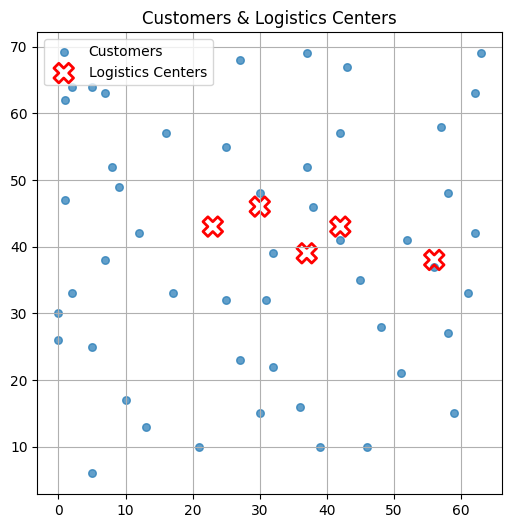

In [12]:
import matplotlib.pyplot as plt

customers_df = pd.read_csv("Customer.csv")
centers_df   = pd.read_csv("DistributionCenter.csv")

plt.figure(figsize=(6,6))

plt.scatter(customers_df["X"], customers_df["Y"],
            s=30, alpha=0.7, label="Customers")

plt.scatter(centers_df["X"], centers_df["Y"],
            marker="X", s=200, linewidths=2,
            edgecolors="red", facecolors="none",
            label="Logistics Centers")

plt.legend()
plt.grid(True)
plt.title("Customers & Logistics Centers")
plt.show()


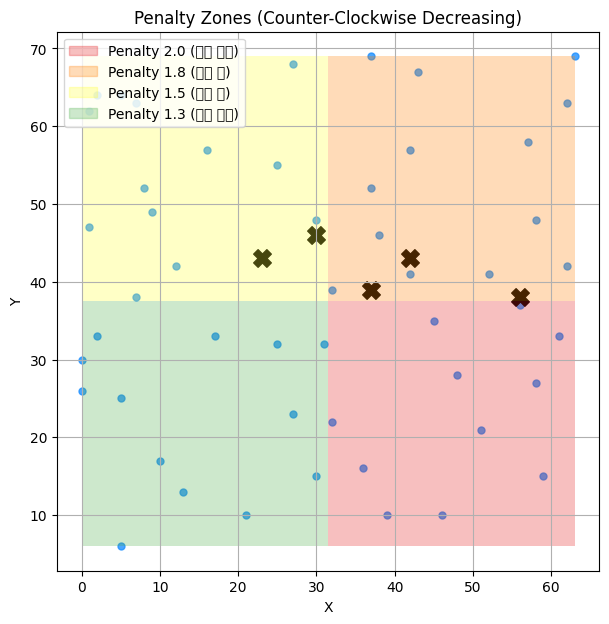

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# --------------------------------------------------
# 1. 구간 기준 계산
# --------------------------------------------------
x_min, x_max = cust_xy[:,0].min(), cust_xy[:,0].max()
y_min, y_max = cust_xy[:,1].min(), cust_xy[:,1].max()

x_mid = (x_min + x_max) / 2.0
y_mid = (y_min + y_max) / 2.0

# --------------------------------------------------
# 2. 패널티 (반시계 방향 2.0 → 1.8 → 1.5 → 1.3)
# --------------------------------------------------
P_BR = 2.0   # 우측 아래 (시작점)
P_TR = 1.8   # 우측 위
P_TL = 1.5   # 좌측 위
P_BL = 1.3   # 좌측 아래

def get_penalty(x, y):
    if y <= y_mid:  # 아래쪽
        if x > x_mid:
            return P_BR   # 우측 아래
        else:
            return P_BL   # 좌측 아래
    else:           # 위쪽
        if x > x_mid:
            return P_TR   # 우측 위
        else:
            return P_TL   # 좌측 위

# --------------------------------------------------
# 3. 시각화
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(7,7))

# 고객
ax.scatter(cust_xy[:,0], cust_xy[:,1], s=25,
           color='dodgerblue', alpha=0.8, label='Customers')

# 센터
ax.scatter(dc_xy[:,0], dc_xy[:,1], marker='X',
           s=160, color='black', label='Logistics Centers')

# 색상(확실히 구분되도록)
C_BR = "#e41a1c"   # 빨강 (2.0)
C_TR = "#ff7f00"   # 주황 (1.8)
C_TL = "#ffff33"   # 노랑 (1.5)
C_BL = "#4daf4a"   # 초록 (1.3)

# 우측 아래 (2.0)
ax.add_patch(Rectangle((x_mid, y_min),
                       x_max-x_mid, y_mid-y_min,
                       linewidth=0, facecolor=C_BR, alpha=0.28))

# 우측 위 (1.8)
ax.add_patch(Rectangle((x_mid, y_mid),
                       x_max-x_mid, y_max-y_mid,
                       linewidth=0, facecolor=C_TR, alpha=0.28))

# 좌측 위 (1.5)
ax.add_patch(Rectangle((x_min, y_mid),
                       x_mid-x_min, y_max-y_mid,
                       linewidth=0, facecolor=C_TL, alpha=0.28))

# 좌측 아래 (1.3)
ax.add_patch(Rectangle((x_min, y_min),
                       x_mid-x_min, y_mid-y_min,
                       linewidth=0, facecolor=C_BL, alpha=0.28))

# 범례
legend_handles = [
    mpatches.Patch(color=C_BR, alpha=0.28, label=f"Penalty 2.0 (우측 아래)"),
    mpatches.Patch(color=C_TR, alpha=0.28, label=f"Penalty 1.8 (우측 위)"),
    mpatches.Patch(color=C_TL, alpha=0.28, label=f"Penalty 1.5 (좌측 위)"),
    mpatches.Patch(color=C_BL, alpha=0.28, label=f"Penalty 1.3 (좌측 아래)")
]

ax.legend(handles=legend_handles, loc='upper left')
ax.set_title("Penalty Zones (Counter-Clockwise Decreasing)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.grid(True)
plt.show()


In [22]:
import pandas as pd
import numpy as np
from math import atan2, sqrt
from itertools import combinations

# -----------------------
# 1) 데이터 불러오기
# -----------------------
cust = pd.read_csv("Customer.csv")            # X, Y, DEMAND
dc   = pd.read_csv("DistributionCenter.csv")  # X, Y, CAPACITY, COST
truck = pd.read_csv("Truck.csv")              # CAPACITY (160)

cust_xy = cust[["X", "Y"]].values
demand  = cust["DEMAND"].values
dc_xy   = dc[["X", "Y"]].values
truck_cap = int(truck["CAPACITY"].iloc[0])    # 160

N = cust_xy.shape[0]
M = dc_xy.shape[0]

# -----------------------
# 2) Depot 선택 (예: p-median 결과 중 하나)
# -----------------------
DEPOT_IDX = 1  # 0~4 중 네가 골라서 바꿔도 됨
depot = dc_xy[DEPOT_IDX]

# -----------------------
# 3) 패널티 함수 (BR 2.0 → TR 1.8 → TL 1.5 → BL 1.3)
# -----------------------
x_min, x_max = cust_xy[:,0].min(), cust_xy[:,0].max()
y_min, y_max = cust_xy[:,1].min(), cust_xy[:,1].max()
x_mid = (x_min + x_max) / 2.0
y_mid = (y_min + y_max) / 2.0

def get_penalty(x, y):
    # bottom / top
    if y <= y_mid:  # 아래쪽
        if x > x_mid:
            return 2.0   # BR (가장 혼잡)
        else:
            return 1.3   # BL
    else:  # 위쪽
        if x > x_mid:
            return 1.8   # TR
        else:
            return 1.5   # TL

penalty = np.array([get_penalty(x, y) for x, y in cust_xy])  # shape (N,)

# -----------------------
# 4) 기본 거리 + 패널티 반영 거리
# -----------------------
def euclid(a, b):
    return sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

# 고객↔고객 기본 거리
dist_cust_base = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        dist_cust_base[i, j] = euclid(cust_xy[i], cust_xy[j])

# depot↔고객 기본 거리
dist_depot_base = np.array([euclid(depot, cust_xy[i]) for i in range(N)])

# 패널티 반영 거리
# depot -> i : dist * penalty_i
pen_depot = dist_depot_base * penalty        # shape (N,)

# i -> j : dist * (penalty_i + penalty_j)/2
pen_cust = dist_cust_base * (penalty[:,None] + penalty[None,:]) / 2.0  # (N,N)

# -----------------------
# 5) 한 route의 총 비용 (패널티 포함)
# route = [i, j, k, ...] (고객 인덱스)
# -----------------------
def route_cost(route):
    if not route:
        return 0.0
    cost = 0.0
    # depot -> first
    cost += pen_depot[route[0]]
    # between customers
    for a, b in zip(route[:-1], route[1:]):
        cost += pen_cust[a, b]
    # last -> depot
    cost += pen_depot[route[-1]]
    return cost

# Capacity 체크
def route_load(route):
    return demand[list(route)].sum()


In [23]:
def clarke_wright(pen_depot, pen_cust, demand, capacity):
    N = len(demand)

    # 1) 초기 route: 각 고객이 단일 route
    routes = [[i] for i in range(N)]
    route_load = [demand[i] for i in range(N)]
    route_ends = [(r[0], r[0]) for r in routes]  # (head, tail)
    cust_to_route = list(range(N))  # 고객→route index

    # 2) Savings 계산
    savings = []
    for i, j in combinations(range(N), 2):
        s = pen_depot[i] + pen_depot[j] - pen_cust[i, j]
        savings.append((s, i, j))
    savings.sort(reverse=True, key=lambda x: x[0])  # 큰 순

    # 3) Savings 순으로 merge 시도
    for s, i, j in savings:
        ri = cust_to_route[i]
        rj = cust_to_route[j]
        if ri == rj:
            continue  # 이미 같은 route

        head_i, tail_i = route_ends[ri]
        head_j, tail_j = route_ends[rj]

        # 용량 확인
        if route_load[ri] + route_load[rj] > capacity:
            continue

        # i가 tail, j가 head 인 경우만 단순 merge 허용 (기본 버전)
        if i == tail_i and j == head_j:
            new_route = routes[ri] + routes[rj]
        elif j == tail_j and i == head_i:
            new_route = routes[rj] + routes[ri]
        else:
            continue  # 양 끝이 아니면 단순 merge 복잡 → 여기선 skip

        new_load = route_load[ri] + route_load[rj]

        new_idx = min(ri, rj)
        old_idx = max(ri, rj)
        routes[new_idx] = new_route
        route_load[new_idx] = new_load
        route_ends[new_idx] = (new_route[0], new_route[-1])

        # 제거된 route는 비우기
        routes[old_idx] = []
        route_load[old_idx] = 0
        route_ends[old_idx] = (-1, -1)

        # 고객→route index 갱신
        for c in new_route:
            cust_to_route[c] = new_idx

    final_routes = [r for r in routes if len(r) > 0]
    return final_routes

cw_routes = clarke_wright(pen_depot, pen_cust, demand, truck_cap)

print("=== Clarke-Wright (with penalty) Routes ===")
total_cw_cost = 0.0
for k, r in enumerate(cw_routes, start=1):
    rc = route_cost(r)
    total_cw_cost += rc
    print(f"Route {k}: depot -> {' -> '.join(map(str, r))} -> depot | load={route_load(r)}, cost={rc:.2f}")
print(f"Total penalized cost (Clarke-Wright) = {total_cw_cost:.2f}")


=== Clarke-Wright (with penalty) Routes ===
Route 1: depot -> 31 -> 0 -> 26 -> 13 -> 17 -> 46 -> 11 -> depot | load=150, cost=110.12
Route 2: depot -> 47 -> 22 -> 6 -> 42 -> 2 -> 7 -> 5 -> 23 -> 1 -> depot | load=157, cost=156.01
Route 3: depot -> 41 -> 18 -> 39 -> 40 -> 12 -> 3 -> 4 -> 8 -> 24 -> 45 -> depot | load=153, cost=172.65
Route 4: depot -> 10 -> 15 -> 37 -> 48 -> 9 -> 38 -> 32 -> 44 -> 14 -> 43 -> 36 -> 16 -> depot | load=157, cost=205.94
Route 5: depot -> 49 -> 29 -> 33 -> 20 -> 28 -> 19 -> 34 -> 35 -> 27 -> 30 -> 25 -> 21 -> depot | load=160, cost=272.44
Total penalized cost (Clarke-Wright) = 917.16


In [24]:
def sweep_vrp(cust_xy, demand, depot, capacity):
    N = len(demand)
    angles = []
    for i in range(N):
        dx = cust_xy[i,0] - depot[0]
        dy = cust_xy[i,1] - depot[1]
        theta = atan2(dy, dx)  # -pi ~ pi
        angles.append((theta, i))
    angles.sort()

    routes = []
    cur_route = []
    cur_load = 0

    for theta, i in angles:
        if cur_load + demand[i] <= capacity:
            cur_route.append(i)
            cur_load += demand[i]
        else:
            if cur_route:
                routes.append(cur_route)
            cur_route = [i]
            cur_load = demand[i]

    if cur_route:
        routes.append(cur_route)

    return routes

sweep_routes = sweep_vrp(cust_xy, demand, depot, truck_cap)

print("=== Sweep Routes (before 2-opt) ===")
for k, r in enumerate(sweep_routes, start=1):
    print(f"Route {k}: depot -> {' -> '.join(map(str, r))} -> depot | load={route_load(r):.1f}, cost={route_cost(r):.2f}")


=== Sweep Routes (before 2-opt) ===
Route 1: depot -> 24 -> 8 -> 4 -> 17 -> 3 -> 12 -> 46 -> depot | load=158.0, cost=158.19
Route 2: depot -> 40 -> 39 -> 18 -> 11 -> 16 -> 41 -> 36 -> 43 -> 14 -> 44 -> 32 -> depot | load=156.0, cost=277.30
Route 3: depot -> 9 -> 38 -> 48 -> 29 -> 37 -> 33 -> 49 -> 20 -> 15 -> 10 -> 28 -> depot | load=155.0, cost=318.84
Route 4: depot -> 19 -> 34 -> 35 -> 21 -> 27 -> 31 -> 0 -> 30 -> 25 -> 47 -> 26 -> 22 -> depot | load=158.0, cost=331.03
Route 5: depot -> 6 -> 42 -> 2 -> 7 -> 23 -> 1 -> 5 -> 13 -> 45 -> depot | load=150.0, cost=164.75


In [25]:
def two_opt(route):
    best = route[:]
    best_cost = route_cost(best)
    improved = True

    while improved:
        improved = False
        L = len(best)
        # i, j 사이 reversed
        for i in range(1, L-1):
            for j in range(i+1, L):
                new_route = best[:i] + best[i:j+1][::-1] + best[j+1:]
                new_cost = route_cost(new_route)
                if new_cost + 1e-6 < best_cost:
                    best = new_route
                    best_cost = new_cost
                    improved = True
                    break
            if improved:
                break
    return best, best_cost

# Sweep + 2-opt 결과
opt_routes = []
total_opt_cost = 0.0
print("\n=== Sweep + 2-opt (with penalty) ===")
for k, r in enumerate(sweep_routes, start=1):
    new_r, new_c = two_opt(r)
    opt_routes.append(new_r)
    total_opt_cost += new_c
    print(f"Route {k}: depot -> {' -> '.join(map(str, new_r))} -> depot | load={route_load(new_r):.1f}, cost={new_c:.2f}")
print(f"Total penalized cost (Sweep + 2-opt) = {total_opt_cost:.2f}")



=== Sweep + 2-opt (with penalty) ===
Route 1: depot -> 24 -> 8 -> 4 -> 3 -> 12 -> 17 -> 46 -> depot | load=158.0, cost=118.73
Route 2: depot -> 40 -> 39 -> 18 -> 41 -> 43 -> 44 -> 32 -> 14 -> 36 -> 16 -> 11 -> depot | load=156.0, cost=201.23
Route 3: depot -> 9 -> 38 -> 29 -> 48 -> 37 -> 49 -> 33 -> 20 -> 28 -> 15 -> 10 -> depot | load=155.0, cost=234.66
Route 4: depot -> 19 -> 34 -> 35 -> 27 -> 30 -> 25 -> 22 -> 47 -> 26 -> 0 -> 21 -> 31 -> depot | load=158.0, cost=247.37
Route 5: depot -> 6 -> 42 -> 2 -> 7 -> 23 -> 1 -> 5 -> 13 -> 45 -> depot | load=150.0, cost=164.75
Total penalized cost (Sweep + 2-opt) = 966.75


In [26]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

def plot_vrp_routes(routes, cust_xy, depot,
                    x_min=None, x_max=None, y_min=None, y_max=None,
                    x_mid=None, y_mid=None,
                    show_penalty_zones=True,
                    title="VRP Routes with Penalty Zones"):
    """
    routes : 리스트의 리스트, 예) [[0, 5, 2], [1, 3, 4, 7], ...]
             각 숫자는 Customer.csv의 index
    cust_xy: shape (N,2) 고객 좌표
    depot  : (2,) depot 좌표 (선택한 DC)
    x_min..y_max, x_mid, y_mid : 패널티 구역 경계 (없으면 자동 계산)
    """

    cust_xy = np.asarray(cust_xy)
    depot   = np.asarray(depot)

    # 범위 자동 계산
    if x_min is None: x_min = cust_xy[:,0].min()
    if x_max is None: x_max = cust_xy[:,0].max()
    if y_min is None: y_min = cust_xy[:,1].min()
    if y_max is None: y_max = cust_xy[:,1].max()
    if x_mid is None: x_mid = (x_min + x_max) / 2.0
    if y_mid is None: y_mid = (y_min + y_max) / 2.0

    fig, ax = plt.subplots(figsize=(8, 8))

    # 0) 패널티 구역 배경 (선택)
    if show_penalty_zones:
        # 색상은 대충 예쁘게 구분되게 설정
        C_BR = "#e41a1c"   # bottom-right, 2.0
        C_TR = "#ff7f00"   # top-right,    1.8
        C_TL = "#ffff33"   # top-left,     1.5
        C_BL = "#4daf4a"   # bottom-left,  1.3

        # BL (좌하, 1.3)
        ax.add_patch(Rectangle((x_min, y_min),
                               x_mid-x_min, y_mid-y_min,
                               linewidth=0, facecolor=C_BL, alpha=0.15))
        # BR (우하, 2.0)
        ax.add_patch(Rectangle((x_mid, y_min),
                               x_max-x_mid, y_mid-y_min,
                               linewidth=0, facecolor=C_BR, alpha=0.15))
        # TL (좌상, 1.5)
        ax.add_patch(Rectangle((x_min, y_mid),
                               x_mid-x_min, y_max-y_mid,
                               linewidth=0, facecolor=C_TL, alpha=0.15))
        # TR (우상, 1.8)
        ax.add_patch(Rectangle((x_mid, y_mid),
                               x_max-x_mid, y_max-y_mid,
                               linewidth=0, facecolor=C_TR, alpha=0.15))

    # 1) 모든 고객 먼저 회색 점으로 찍기
    ax.scatter(cust_xy[:,0], cust_xy[:,1],
               s=20, color="lightgray", label="Customers (all)")

    # 2) depot 표시 (선택한 DC)
    ax.scatter(depot[0], depot[1],
               marker="s", s=150, color="black", label="Depot")

    # 3) route별로 색 다르게 그리기
    cmap = plt.cm.get_cmap("tab20", len(routes))

    for ridx, route in enumerate(routes):
        if len(route) == 0:
            continue
        route = list(route)

        # 경로 좌표: depot → 고객들 → depot
        pts = np.vstack([
            depot,
            cust_xy[route],
            depot
        ])

        # 선 + 고객 점
        ax.plot(pts[:,0], pts[:,1],
                "-", linewidth=2, color=cmap(ridx),
                label=f"Route {ridx+1}" if ridx < 20 else None)
        ax.scatter(cust_xy[route,0], cust_xy[route,1],
                   s=40, color=cmap(ridx))

        # 각 고객 옆에 index 표기
        for i in route:
            ax.text(cust_xy[i,0]+0.5, cust_xy[i,1]+0.5,
                    str(i), fontsize=8, color=cmap(ridx))

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title(title)
    ax.grid(True)
    ax.set_aspect("equal", adjustable="box")

    # 범례는 겹치지 않게 한 번만 정리
    handles, labels = ax.get_legend_handles_labels()
    # 중복 제거
    seen = set()
    unique_h, unique_l = [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            seen.add(l)
            unique_h.append(h)
            unique_l.append(l)
    ax.legend(unique_h, unique_l, loc="upper left")

    plt.show()


/tmp/ipython-input-380253977.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(routes))


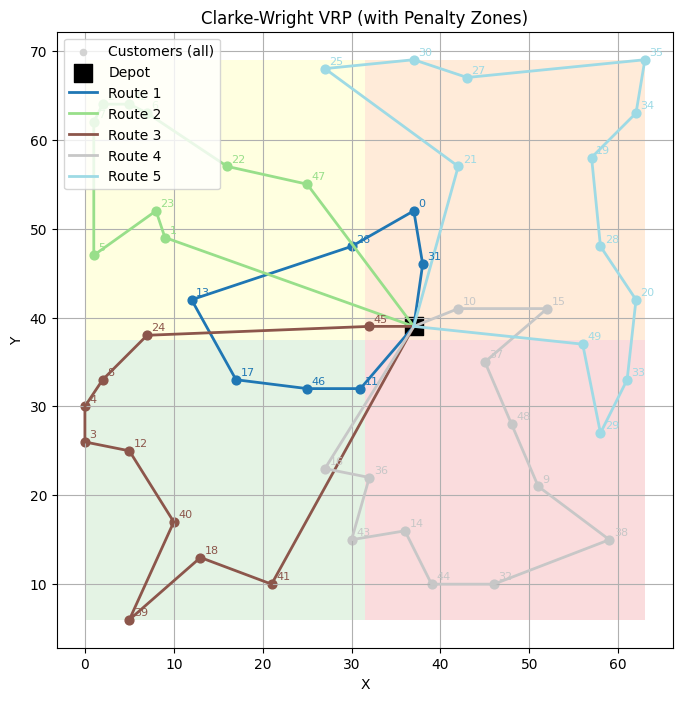

In [27]:
# cw_routes, cust_xy, depot, x_min..y_mid 등은 앞에서 이미 계산한 것 사용
plot_vrp_routes(
    routes=cw_routes,
    cust_xy=cust_xy,
    depot=depot,
    x_min=x_min, x_max=x_max,
    y_min=y_min, y_max=y_max,
    x_mid=x_mid, y_mid=y_mid,
    show_penalty_zones=True,
    title="Clarke-Wright VRP (with Penalty Zones)"
)


/tmp/ipython-input-380253977.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(routes))


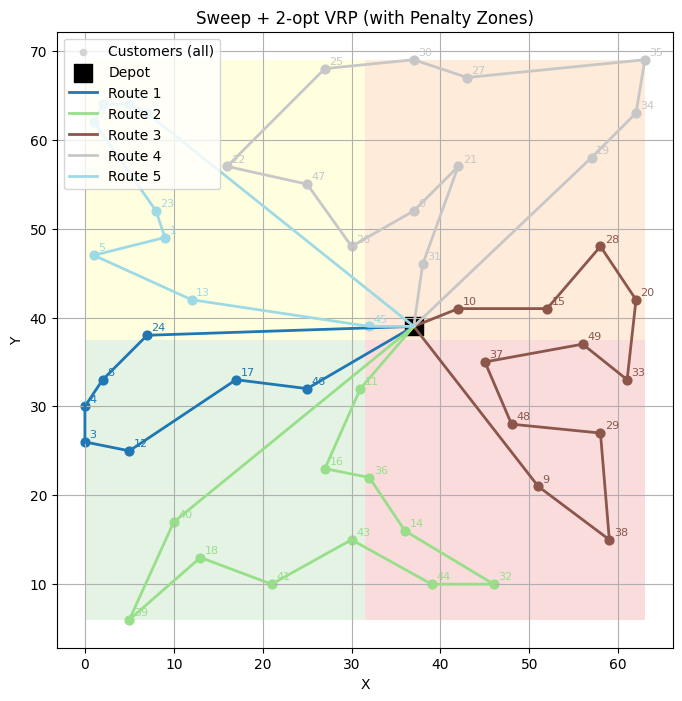

In [28]:
plot_vrp_routes(
    routes=opt_routes,   # two_opt 적용한 최종 routes
    cust_xy=cust_xy,
    depot=depot,
    x_min=x_min, x_max=x_max,
    y_min=y_min, y_max=y_max,
    x_mid=x_mid, y_mid=y_mid,
    show_penalty_zones=True,
    title="Sweep + 2-opt VRP (with Penalty Zones)"
)


In [29]:
import pandas as pd
import numpy as np
from math import atan2, sqrt, inf
from itertools import combinations

# -----------------------
# 1) 데이터 불러오기
# -----------------------
cust = pd.read_csv("Customer.csv")            # X, Y, DEMAND
dc   = pd.read_csv("DistributionCenter.csv")  # X, Y, (COST 있으면 나중에 사용)
truck = pd.read_csv("Truck.csv")              # CAPACITY (160)

cust_xy = cust[["X", "Y"]].values
demand  = cust["DEMAND"].values
dc_xy   = dc[["X", "Y"]].values
truck_cap = int(truck["CAPACITY"].iloc[0])    # 160

N = cust_xy.shape[0]
M = dc_xy.shape[0]

# -----------------------
# 2) 패널티 함수 (BR 2.0 → TR 1.8 → TL 1.5 → BL 1.3)
# -----------------------
x_min, x_max = cust_xy[:,0].min(), cust_xy[:,0].max()
y_min, y_max = cust_xy[:,1].min(), cust_xy[:,1].max()
x_mid = (x_min + x_max) / 2.0
y_mid = (y_min + y_max) / 2.0

def get_penalty(x, y):
    # 아래쪽
    if y <= y_mid:
        # 우하단 (BR)
        if x > x_mid:
            return 2.0   # 가장 혼잡
        # 좌하단 (BL)
        else:
            return 1.3
    # 위쪽
    else:
        # 우상단 (TR)
        if x > x_mid:
            return 1.8
        # 좌상단 (TL)
        else:
            return 1.5

penalty = np.array([get_penalty(x, y) for x, y in cust_xy])  # (N,)

# -----------------------
# 3) 거리 함수
# -----------------------
def euclid(a, b):
    return sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

# 고객↔고객 기본 거리
dist_cust_base = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        dist_cust_base[i, j] = euclid(cust_xy[i], cust_xy[j])

# depot(DC)↔고객 기본 거리: shape (M, N)
dist_depot_base = np.zeros((M, N))
for j in range(M):
    for i in range(N):
        dist_depot_base[j, i] = euclid(dc_xy[j], cust_xy[i])

# 패널티 반영
# depot j -> 고객 i : dist * penalty_i
pen_depot = dist_depot_base * penalty[None, :]  # (M, N)

# 고객 i -> j : dist * (pen_i + pen_j)/2
pen_cust = dist_cust_base * (penalty[:,None] + penalty[None,:]) / 2.0  # (N, N)

# -----------------------
# 4) route 비용 / 적재량 함수
# -----------------------
def route_cost(route, depot_idx):
    """route: 고객 index 리스트, depot_idx: DC index (0~4)"""
    if not route:
        return 0.0
    d_cost = 0.0
    # depot -> 첫 고객
    first = route[0]
    d_cost += pen_depot[depot_idx, first]
    # 고객 사이
    for a, b in zip(route[:-1], route[1:]):
        d_cost += pen_cust[a, b]
    # 마지막 고객 -> depot
    last = route[-1]
    d_cost += pen_depot[depot_idx, last]
    return d_cost

def route_load(route):
    return demand[list(route)].sum()


In [30]:
def clarke_wright_for_depot(cust_indices, depot_idx, capacity):
    """
    cust_indices: 이 DC가 담당하는 고객 index 리스트 (전역 index)
    depot_idx: DC index (0~4)
    capacity: 트럭 용량 (160)
    """
    if len(cust_indices) == 0:
        return []

    # local index 매핑: 0..n_local-1
    idx_map = {local:i for i, local in enumerate(cust_indices)}
    inv_idx = {i:local for local, i in idx_map.items()}
    n_local = len(cust_indices)

    # 로컬 수요
    dem_local = np.array([demand[inv_idx[k]] for k in range(n_local)])

    # 로컬 비용 행렬 (패널티 포함)
    # depot -> i
    dep_local = np.array([pen_depot[depot_idx, inv_idx[k]] for k in range(n_local)])
    # i -> j
    cust_local = np.zeros((n_local, n_local))
    for i in range(n_local):
        for j in range(n_local):
            cust_local[i, j] = pen_cust[inv_idx[i], inv_idx[j]]

    # 초기 route: 각 고객 단독
    routes = [[i] for i in range(n_local)]
    route_loads = [dem_local[i] for i in range(n_local)]
    route_ends  = [(r[0], r[0]) for r in routes]    # (head, tail)
    cust_to_route = list(range(n_local))

    # savings 계산
    sv = []
    for i, j in combinations(range(n_local), 2):
        s = dep_local[i] + dep_local[j] - cust_local[i, j]
        sv.append((s, i, j))
    sv.sort(reverse=True, key=lambda x: x[0])

    # merge
    for s, i, j in sv:
        ri = cust_to_route[i]
        rj = cust_to_route[j]
        if ri == rj:
            continue

        head_i, tail_i = route_ends[ri]
        head_j, tail_j = route_ends[rj]

        if route_loads[ri] + route_loads[rj] > capacity:
            continue

        # 단순 버전: i가 tail, j가 head일 때만 merge
        if i == tail_i and j == head_j:
            new_route = routes[ri] + routes[rj]
        elif j == tail_j and i == head_i:
            new_route = routes[rj] + routes[ri]
        else:
            continue

        new_load = route_loads[ri] + route_loads[rj]

        new_idx = min(ri, rj)
        old_idx = max(ri, rj)

        routes[new_idx] = new_route
        route_loads[new_idx] = new_load
        route_ends[new_idx] = (new_route[0], new_route[-1])

        routes[old_idx] = []
        route_loads[old_idx] = 0
        route_ends[old_idx] = (-1, -1)

        for c in new_route:
            cust_to_route[c] = new_idx

    # 빈 route 제거 + 전역 index로 되돌리기
    final_routes = []
    for r in routes:
        if len(r) == 0:
            continue
        # local idx → global customer idx
        global_route = [inv_idx[k] for k in r]
        final_routes.append(global_route)

    return final_routes


In [31]:
def eval_dc_subset_dcvrp(subset):
    """
    subset: 사용할 DC index 튜플 (예: (1,2) )
    return: total_cost, routes_by_dc (dict: dc_idx -> [route 리스트])
    """
    subset = list(subset)
    K = len(subset)

    # 1) 고객 할당: 각 고객 i를 subset의 DC 중 최소 비용에 할당
    #    할당 비용 기준: dist_depot_base * penalty * demand
    alloc_cost = dist_depot_base[subset, :] * penalty[None, :] * demand[None, :]
    # shape (K, N) → 각 (dc, customer) 비용
    best_dc_idx = subset[np.argmin(alloc_cost, axis=0)]   # length N

    # dc별 고객 모으기
    cust_by_dc = {dc_idx: [] for dc_idx in subset}
    for i in range(N):
        dc_idx = best_dc_idx[i]
        cust_by_dc[dc_idx].append(i)

    # 2) DC별로 CVRP 수행
    total_cost = 0.0
    routes_by_dc = {}

    for dc_idx in subset:
        assigned_custs = cust_by_dc[dc_idx]
        if len(assigned_custs) == 0:
            routes_by_dc[dc_idx] = []
            continue

        # Clarke–Wright for this depot
        depot_routes = clarke_wright_for_depot(assigned_custs, dc_idx, truck_cap)
        routes_by_dc[dc_idx] = depot_routes

        # route 비용 계산
        for r in depot_routes:
            total_cost += route_cost(r, dc_idx)

    # (옵션) DC 고정비가 있다면 여기에 더해줄 수 있음
    # open_cost = dc.loc[list(subset), "COST"].sum()
    # total_cost += open_cost

    return total_cost, routes_by_dc


=== Multi-Depot VRP + Facility Choice (with penalties) ===
최소 총비용: 847.04
선택된 DC 개수 p: 3
선택된 DC index (0부터): (0, 2, 3)
선택된 DC 좌표:
  DC1: (30, 46)
  DC3: (23, 43)
  DC4: (56, 38)


/tmp/ipython-input-1026832859.py:294: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 20)


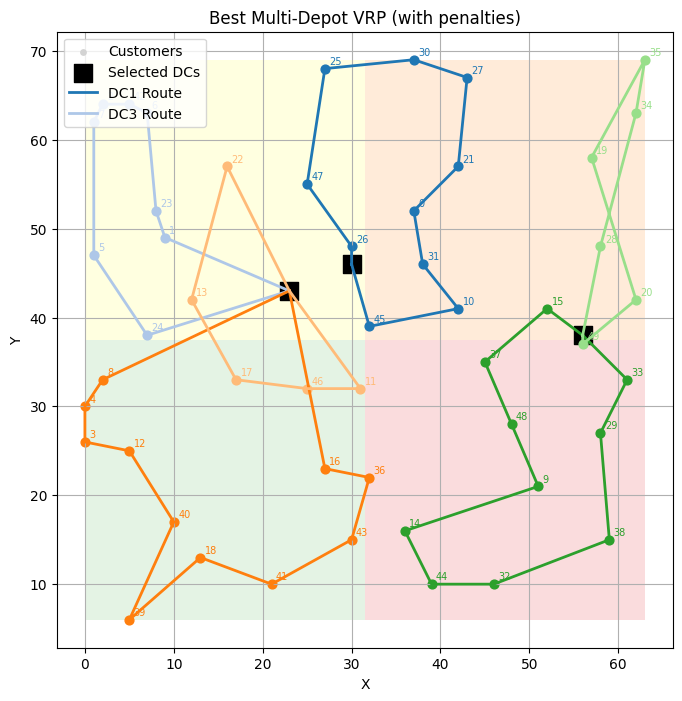

In [33]:
import pandas as pd
import numpy as np
from math import atan2, sqrt, inf
from itertools import combinations
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# ===========================================
# 1. 데이터 불러오기
# ===========================================
cust = pd.read_csv("Customer.csv")            # X, Y, DEMAND
dc   = pd.read_csv("DistributionCenter.csv")  # X, Y (COST 등은 있으면 나중에 사용 가능)
truck = pd.read_csv("Truck.csv")              # CAPACITY (160)

cust_xy = cust[["X", "Y"]].values
demand  = cust["DEMAND"].values
dc_xy   = dc[["X", "Y"]].values
truck_cap = int(truck["CAPACITY"].iloc[0])    # 예: 160

N = cust_xy.shape[0]
M = dc_xy.shape[0]

# ===========================================
# 2. 패널티 함수 (BR 2.0 → TR 1.8 → TL 1.5 → BL 1.3)
# ===========================================
x_min, x_max = cust_xy[:,0].min(), cust_xy[:,0].max()
y_min, y_max = cust_xy[:,1].min(), cust_xy[:,1].max()
x_mid = (x_min + x_max) / 2.0
y_mid = (y_min + y_max) / 2.0

def get_penalty(x, y):
    # 아래쪽
    if y <= y_mid:
        if x > x_mid:
            return 2.0   # BR (우하단, 가장 혼잡)
        else:
            return 1.3   # BL (좌하단)
    # 위쪽
    else:
        if x > x_mid:
            return 1.8   # TR (우상단)
        else:
            return 1.5   # TL (좌상단)

penalty = np.array([get_penalty(x, y) for x, y in cust_xy])  # (N,)

# ===========================================
# 3. 거리 및 패널티 반영 비용
# ===========================================
def euclid(a, b):
    return sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

# 고객↔고객 기본 거리
dist_cust_base = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        dist_cust_base[i, j] = euclid(cust_xy[i], cust_xy[j])

# DC(후보지)↔고객 기본 거리: shape (M, N)
dist_depot_base = np.zeros((M, N))
for j in range(M):
    for i in range(N):
        dist_depot_base[j, i] = euclid(dc_xy[j], cust_xy[i])

# 패널티 반영
# depot j -> 고객 i : dist * penalty_i
pen_depot = dist_depot_base * penalty[None, :]  # (M, N)

# 고객 i -> j : dist * (pen_i + pen_j)/2
pen_cust = dist_cust_base * (penalty[:,None] + penalty[None,:]) / 2.0  # (N, N)

# ===========================================
# 4. route 비용 / 적재량 함수
# ===========================================
def route_cost(route, depot_idx):
    """route: 고객 index 리스트, depot_idx: DC index (0~M-1)"""
    if not route:
        return 0.0
    cost = 0.0
    # depot -> 첫 고객
    first = route[0]
    cost += pen_depot[depot_idx, first]
    # 고객 사이
    for a, b in zip(route[:-1], route[1:]):
        cost += pen_cust[a, b]
    # 마지막 고객 -> depot
    last = route[-1]
    cost += pen_depot[depot_idx, last]
    return cost

def route_load(route):
    return demand[list(route)].sum()

# ===========================================
# 5. Clarke-Wright VRP (하나의 DC에 대해)
# ===========================================
def clarke_wright_for_depot(cust_indices, depot_idx, capacity):
    """
    cust_indices: 이 DC가 담당하는 고객 index 리스트 (전역 index)
    depot_idx   : DC index (0~M-1)
    capacity    : 트럭 용량 (예: 160)
    """
    if len(cust_indices) == 0:
        return []

    # local index 매핑: 0..n_local-1
    idx_map = {local:i for i, local in enumerate(cust_indices)}
    inv_idx = {i:local for local, i in idx_map.items()}
    n_local = len(cust_indices)

    # 로컬 수요
    dem_local = np.array([demand[inv_idx[k]] for k in range(n_local)])

    # 로컬 비용 행렬 (패널티 포함)
    dep_local = np.array([pen_depot[depot_idx, inv_idx[k]] for k in range(n_local)])
    cust_local = np.zeros((n_local, n_local))
    for i in range(n_local):
        for j in range(n_local):
            cust_local[i, j] = pen_cust[inv_idx[i], inv_idx[j]]

    # 초기 route: 각 고객 단독
    routes = [[i] for i in range(n_local)]
    route_loads = [dem_local[i] for i in range(n_local)]
    route_ends  = [(r[0], r[0]) for r in routes]    # (head, tail)
    cust_to_route = list(range(n_local))

    # savings 계산
    sv = []
    for i, j in combinations(range(n_local), 2):
        s = dep_local[i] + dep_local[j] - cust_local[i, j]
        sv.append((s, i, j))
    sv.sort(reverse=True, key=lambda x: x[0])

    # merge
    for s, i, j in sv:
        ri = cust_to_route[i]
        rj = cust_to_route[j]
        if ri == rj:
            continue

        head_i, tail_i = route_ends[ri]
        head_j, tail_j = route_ends[rj]

        if route_loads[ri] + route_loads[rj] > capacity:
            continue

        # 단순 버전: i가 tail, j가 head일 때만 merge
        if i == tail_i and j == head_j:
            new_route = routes[ri] + routes[rj]
        elif j == tail_j and i == head_i:
            new_route = routes[rj] + routes[ri]
        else:
            continue

        new_load = route_loads[ri] + route_loads[rj]

        new_idx = min(ri, rj)
        old_idx = max(ri, rj)

        routes[new_idx] = new_route
        route_loads[new_idx] = new_load
        route_ends[new_idx] = (new_route[0], new_route[-1])

        routes[old_idx] = []
        route_loads[old_idx] = 0
        route_ends[old_idx] = (-1, -1)

        for c in new_route:
            cust_to_route[c] = new_idx

    # 빈 route 제거 + 전역 index로 되돌리기
    final_routes = []
    for r in routes:
        if len(r) == 0:
            continue
        global_route = [inv_idx[k] for k in r]
        final_routes.append(global_route)

    return final_routes

# ===========================================
# 6. DC 조합(p개)에 대한 총 비용 계산 + VRP
# ===========================================
def eval_dc_subset_dcvrp(subset):
    """
    subset: 사용할 DC index 튜플 (예: (1,2))
    return: total_cost, routes_by_dc (dict: dc_idx -> [route 리스트])
    """
    subset = list(subset)
    subset_arr = np.array(subset)
    K = len(subset)

    # 1) 고객 할당: 각 고객 i를 subset의 DC 중 최소 비용에 할당
    #    비용 = dist_depot_base * penalty * demand
    alloc_cost = dist_depot_base[subset_arr, :] * penalty[None, :] * demand[None, :]
    # shape (K, N)
    best_dc_local = np.argmin(alloc_cost, axis=0)   # (N,)
    best_dc_idx   = subset_arr[best_dc_local]       # (N,)

    # dc별 고객 모으기
    cust_by_dc = {dc_idx: [] for dc_idx in subset}
    for i in range(N):
        dc_idx = int(best_dc_idx[i])
        cust_by_dc[dc_idx].append(i)

    # 2) DC별로 CVRP(Clarke-Wright) 수행
    total_cost = 0.0
    routes_by_dc = {}

    for dc_idx in subset:
        assigned_custs = cust_by_dc[dc_idx]
        if len(assigned_custs) == 0:
            routes_by_dc[dc_idx] = []
            continue

        depot_routes = clarke_wright_for_depot(assigned_custs, dc_idx, truck_cap)
        routes_by_dc[dc_idx] = depot_routes

        for r in depot_routes:
            total_cost += route_cost(r, dc_idx)

    return total_cost, routes_by_dc

# ===========================================
# 7. p = 1~M 전체 탐색해서 최적 p, DC 조합, routes 찾기
# ===========================================
best_overall = None  # (total_cost, p, subset, routes_by_dc)

for p in range(1, M+1):  # M=5
    for subset in combinations(range(M), p):
        total_cost, routes_by_dc = eval_dc_subset_dcvrp(subset)
        if (best_overall is None) or (total_cost < best_overall[0]):
            best_overall = (total_cost, p, subset, routes_by_dc)

best_cost, best_p, best_subset, best_routes_by_dc = best_overall

print("=== Multi-Depot VRP + Facility Choice (with penalties) ===")
print(f"최소 총비용: {best_cost:.2f}")
print(f"선택된 DC 개수 p: {best_p}")
print(f"선택된 DC index (0부터): {best_subset}")
print("선택된 DC 좌표:")
for j in best_subset:
    print(f"  DC{j+1}: ({dc_xy[j,0]}, {dc_xy[j,1]})")

# ===========================================
# 8. 시각화 함수 (여러 depot + penalty zone)
# ===========================================
def plot_multi_depot_routes(routes_by_dc, cust_xy, dc_xy,
                            x_min=None, x_max=None, y_min=None, y_max=None,
                            x_mid=None, y_mid=None,
                            show_penalty_zones=True,
                            title="Multi-Depot VRP with Penalty Zones"):
    cust_xy = np.asarray(cust_xy)
    dc_xy   = np.asarray(dc_xy)

    if x_min is None: x_min = cust_xy[:,0].min()
    if x_max is None: x_max = cust_xy[:,0].max()
    if y_min is None: y_min = cust_xy[:,1].min()
    if y_max is None: y_max = cust_xy[:,1].max()
    if x_mid is None: x_mid = (x_min + x_max) / 2.0
    if y_mid is None: y_mid = (y_min + y_max) / 2.0

    fig, ax = plt.subplots(figsize=(8,8))

    # 패널티 구역
    if show_penalty_zones:
        C_BR = "#e41a1c"   # BR 2.0
        C_TR = "#ff7f00"   # TR 1.8
        C_TL = "#ffff33"   # TL 1.5
        C_BL = "#4daf4a"   # BL 1.3

        ax.add_patch(Rectangle((x_min, y_min),
                               x_mid-x_min, y_mid-y_min,
                               linewidth=0, facecolor=C_BL, alpha=0.15))
        ax.add_patch(Rectangle((x_mid, y_min),
                               x_max-x_mid, y_mid-y_min,
                               linewidth=0, facecolor=C_BR, alpha=0.15))
        ax.add_patch(Rectangle((x_min, y_mid),
                               x_mid-x_min, y_max-y_mid,
                               linewidth=0, facecolor=C_TL, alpha=0.15))
        ax.add_patch(Rectangle((x_mid, y_mid),
                               x_max-x_mid, y_max-y_mid,
                               linewidth=0, facecolor=C_TR, alpha=0.15))

    # 모든 고객
    ax.scatter(cust_xy[:,0], cust_xy[:,1],
               s=15, color="lightgray", label="Customers")

    # 사용된 depot만 표시
    used_dc_indices = [j for j, routes in routes_by_dc.items() if len(routes) > 0]
    ax.scatter(dc_xy[used_dc_indices,0], dc_xy[used_dc_indices,1],
               marker="s", s=150, color="black", label="Selected DCs")

    cmap = plt.cm.get_cmap("tab20", 20)
    color_idx = 0

    for dc_idx, routes in routes_by_dc.items():
        dc_coord = dc_xy[dc_idx]
        for r in routes:
            if len(r) == 0:
                continue
            c = cmap(color_idx % 20)
            color_idx += 1

            pts = np.vstack([
                dc_coord,
                cust_xy[r],
                dc_coord
            ])
            ax.plot(pts[:,0], pts[:,1], "-", linewidth=2, color=c,
                    label=f"DC{dc_idx+1} Route" if color_idx <= len(routes_by_dc) else None)
            ax.scatter(cust_xy[r,0], cust_xy[r,1], s=40, color=c)

            for i in r:
                ax.text(cust_xy[i,0]+0.5, cust_xy[i,1]+0.5,
                        str(i), fontsize=7, color=c)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title(title)
    ax.grid(True)
    ax.set_aspect("equal", adjustable="box")

    handles, labels = ax.get_legend_handles_labels()
    seen = set()
    uniq_h, uniq_l = [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            seen.add(l)
            uniq_h.append(h)
            uniq_l.append(l)
    ax.legend(uniq_h, uniq_l, loc="upper left")

    plt.show()

# ===========================================
# 9. 최적 해 시각화 호출
# ===========================================
plot_multi_depot_routes(
    routes_by_dc=best_routes_by_dc,
    cust_xy=cust_xy,
    dc_xy=dc_xy,
    x_min=x_min, x_max=x_max,
    y_min=y_min, y_max=y_max,
    x_mid=x_mid, y_mid=y_mid,
    show_penalty_zones=True,
    title="Best Multi-Depot VRP (with penalties)"
)



In [36]:
# pip install pulp  # 처음 한 번만

import pulp

def solve_cflp(open_cost_factor=1.0):
    """
    CFLP:
      - 목적: 시설개설비 + 수송비 최소화
      - x_ij: 고객 i를 DC j에 할당
      - y_j : DC j를 여는지 (0/1)
    open_cost_factor: DC 여는 고정비 비중 (원하면 조절)
    """
    total_demand = demand.sum()

    # DC capacity: 컬럼 있으면 사용, 없으면 충분히 크게
    if "CAPACITY" in dc.columns:
        cap = dc["CAPACITY"].values.astype(float)
    else:
        cap = np.full(M, total_demand)  # 사실상 무제한

    # DC 고정비: 있으면 사용, 없으면 거리 scale 정도로 설정
    if "COST" in dc.columns:
        f = dc["COST"].values.astype(float) * open_cost_factor
    else:
        # 기본적으로 depot->mean 고객 cost 정도를 기준으로 세팅
        avg_open_cost = pen_depot.mean(axis=1) * open_cost_factor
        f = avg_open_cost

    # 고객 i가 DC j에 할당될 때 비용: 거리 * penalty * demand
    alloc_cost = dist_depot_base * penalty[None,:] * demand[None,:]  # (M,N)

    prob = pulp.LpProblem("CFLP", pulp.LpMinimize)

    x = pulp.LpVariable.dicts("x", (range(N), range(M)), lowBound=0, upBound=1, cat="Binary")
    y = pulp.LpVariable.dicts("y", range(M), lowBound=0, upBound=1, cat="Binary")

    # 목적함수
    prob += (
        pulp.lpSum(alloc_cost[j,i] * x[i][j] for i in range(N) for j in range(M))
        + pulp.lpSum(f[j] * y[j] for j in range(M))
    )

    # 각 고객은 한 DC에만 할당
    for i in range(N):
        prob += pulp.lpSum(x[i][j] for j in range(M)) == 1

    # Cap 제약: sum(D_i * x_ij) <= cap_j * y_j
    for j in range(M):
        prob += pulp.lpSum(demand[i] * x[i][j] for i in range(N)) <= cap[j] * y[j]

    # 풀기
    prob.solve(pulp.PULP_CBC_CMD(msg=False))

    status = pulp.LpStatus[prob.status]
    print("CFLP Status:", status)
    total_cost = pulp.value(prob.objective)
    print("CFLP Total Cost:", total_cost)

    open_dcs = [j for j in range(M) if pulp.value(y[j]) > 0.5]
    print("Opened DC indices:", open_dcs)

    assign = np.zeros(N, dtype=int)
    for i in range(N):
        for j in range(M):
            if pulp.value(x[i][j]) > 0.5:
                assign[i] = j
                break

    return open_dcs, assign, total_cost

# 예시 실행
# open_dcs, assign, cflp_cost = solve_cflp(open_cost_factor=1.0)


In [37]:
# ===========================================
# 0. 공통 세팅: 데이터, 패널티, 거리, 기본 plot
# ===========================================
import pandas as pd
import numpy as np
from math import sqrt
from itertools import combinations
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# ---------- 0-1. 데이터 불러오기 ----------
cust = pd.read_csv("Customer.csv")            # 컬럼: X, Y, DEMAND
dc   = pd.read_csv("DistributionCenter.csv")  # 컬럼: X, Y, (CAPACITY, COST 선택)
truck = pd.read_csv("Truck.csv")              # 컬럼: CAPACITY (트럭 1대 용량)

cust_xy = cust[["X", "Y"]].values
demand  = cust["DEMAND"].values
dc_xy   = dc[["X", "Y"]].values
truck_cap = int(truck["CAPACITY"].iloc[0])

N = cust_xy.shape[0]
M = dc_xy.shape[0]

# ---------- 0-2. 패널티 (4구역: BR 2.0, TR 1.8, TL 1.5, BL 1.3) ----------
x_min, x_max = cust_xy[:,0].min(), cust_xy[:,0].max()
y_min, y_max = cust_xy[:,1].min(), cust_xy[:,1].max()
x_mid = (x_min + x_max) / 2.0
y_mid = (y_min + y_max) / 2.0

def get_penalty(x, y):
    # 아래쪽
    if y <= y_mid:
        if x > x_mid:
            return 2.0   # BR (우하단, 가장 혼잡)
        else:
            return 1.3   # BL (좌하단)
    # 위쪽
    else:
        if x > x_mid:
            return 1.8   # TR (우상단)
        else:
            return 1.5   # TL (좌상단)

penalty = np.array([get_penalty(x, y) for x, y in cust_xy])  # shape (N,)

# ---------- 0-3. 거리 + 패널티 반영 ----------
def euclid(a, b):
    return sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

# 고객↔고객
dist_cust_base = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        dist_cust_base[i, j] = euclid(cust_xy[i], cust_xy[j])

# DC↔고객
dist_depot_base = np.zeros((M, N))
for j in range(M):
    for i in range(N):
        dist_depot_base[j, i] = euclid(dc_xy[j], cust_xy[i])

# 패널티 반영
# depot j -> 고객 i : dist * penalty_i
pen_depot = dist_depot_base * penalty[None, :]          # (M, N)
# 고객 i -> 고객 k : dist * (pen_i + pen_k)/2
pen_cust  = dist_cust_base * (penalty[:,None] + penalty[None,:]) / 2.0

# ---------- 0-4. 공통 route 함수 ----------
def route_cost(route, depot_idx):
    """route: 고객 index 리스트, depot_idx: DC index (0~M-1)"""
    if not route:
        return 0.0
    c = 0.0
    first = route[0]
    c += pen_depot[depot_idx, first]
    for a, b in zip(route[:-1], route[1:]):
        c += pen_cust[a, b]
    last = route[-1]
    c += pen_depot[depot_idx, last]
    return c

def route_load(route):
    return demand[list(route)].sum()

def total_vrp_cost(routes, depot_idx):
    return sum(route_cost(r, depot_idx) for r in routes)

# ---------- 0-5. 공통 시각화: penalty zone + 고객 + DC ----------
def plot_base(ax=None, show_penalty_zones=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8))

    if show_penalty_zones:
        C_BR = "#e41a1c"   # BR 2.0
        C_TR = "#ff7f00"   # TR 1.8
        C_TL = "#ffff33"   # TL 1.5
        C_BL = "#4daf4a"   # BL 1.3

        ax.add_patch(Rectangle((x_min, y_min),
                               x_mid-x_min, y_mid-y_min,
                               linewidth=0, facecolor=C_BL, alpha=0.15))
        ax.add_patch(Rectangle((x_mid, y_min),
                               x_max-x_mid, y_mid-y_min,
                               linewidth=0, facecolor=C_BR, alpha=0.15))
        ax.add_patch(Rectangle((x_min, y_mid),
                               x_mid-x_min, y_max-y_mid,
                               linewidth=0, facecolor=C_TL, alpha=0.15))
        ax.add_patch(Rectangle((x_mid, y_mid),
                               x_max-x_mid, y_max-y_mid,
                               linewidth=0, facecolor=C_TR, alpha=0.15))

    # 모든 고객
    ax.scatter(cust_xy[:,0], cust_xy[:,1],
               s=20, color="lightgray", label="Customers")
    # 모든 DC
    ax.scatter(dc_xy[:,0], dc_xy[:,1],
               marker="s", s=120, color="black", label="All DCs")

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(True)
    ax.set_aspect("equal", adjustable="box")
    return ax

# ---------- 0-6. 시설입지/할당 시각화 (CFLP, GA 공용) ----------
def plot_facility_assignment(open_dcs, assign, title="Facility Location / Assignment"):
    fig, ax = plt.subplots(figsize=(8,8))
    plot_base(ax)

    open_dcs = list(open_dcs)
    # 선택된 DC 강조
    ax.scatter(dc_xy[open_dcs,0], dc_xy[open_dcs,1],
               marker="s", s=160, color="red", label="Opened DCs")

    # 고객 → 할당된 DC로 선 그리기
    for i in range(N):
        j = assign[i]
        x1, y1 = cust_xy[i]
        x2, y2 = dc_xy[j]
        ax.plot([x1, x2], [y1, y2], "-", color="gray", alpha=0.3)

    ax.set_title(title)
    handles, labels = ax.get_legend_handles_labels()
    seen = set()
    H, L = [], []
    for h,l in zip(handles, labels):
        if l not in seen:
            seen.add(l)
            H.append(h); L.append(l)
    ax.legend(H, L, loc="upper left")
    plt.show()

# ---------- 0-7. VRP route 시각화 (단일 depot) ----------
def plot_vrp_routes(routes, depot_idx, title="VRP Routes"):
    fig, ax = plt.subplots(figsize=(8,8))
    plot_base(ax)

    depot = dc_xy[depot_idx]
    ax.scatter(depot[0], depot[1],
               marker="s", s=200, color="red", label=f"Depot DC{depot_idx+1}")

    cmap = plt.cm.get_cmap("tab20", 20)
    cidx = 0

    for r in routes:
        if not r:
            continue
        color = cmap(cidx % 20)
        cidx += 1
        pts = np.vstack([depot, cust_xy[r], depot])
        ax.plot(pts[:,0], pts[:,1], "-", linewidth=2, color=color)
        ax.scatter(cust_xy[r,0], cust_xy[r,1], s=40, color=color)
        for i in r:
            ax.text(cust_xy[i,0]+0.5, cust_xy[i,1]+0.5,
                    str(i), fontsize=7, color=color)

    ax.set_title(title)
    handles, labels = ax.get_legend_handles_labels()
    seen = set()
    H, L = [], []
    for h,l in zip(handles, labels):
        if l not in seen:
            seen.add(l); H.append(h); L.append(l)
    ax.legend(H, L, loc="upper left")
    plt.show()

# ===========================================
# 1. CFLP (Capacitated Facility Location, PuLP) + 시각화
# ===========================================
import pulp

def solve_cflp(open_cost_factor=1.0):
    """
    CFLP:
      목적: 시설개설비 + 수송비 최소화
      x_ij: 고객 i를 DC j에 할당 (Binary)
      y_j : DC j를 여는지 여부 (Binary)
    """
    total_demand = demand.sum()

    # DC capacity
    if "CAPACITY" in dc.columns:
        cap = dc["CAPACITY"].values.astype(float)
    else:
        cap = np.full(M, total_demand)

    # DC fixed cost
    if "COST" in dc.columns:
        f = dc["COST"].values.astype(float) * open_cost_factor
    else:
        avg_open_cost = pen_depot.mean(axis=1) * open_cost_factor
        f = avg_open_cost

    # 고객 i → DC j 할당 비용 (거리 * penalty * demand)
    alloc_cost = dist_depot_base * penalty[None,:] * demand[None,:]  # (M,N)

    prob = pulp.LpProblem("CFLP", pulp.LpMinimize)

    x = pulp.LpVariable.dicts("x", (range(N), range(M)), 0, 1, cat="Binary")
    y = pulp.LpVariable.dicts("y", range(M), 0, 1, cat="Binary")

    prob += (
        pulp.lpSum(alloc_cost[j,i] * x[i][j] for i in range(N) for j in range(M))
        + pulp.lpSum(f[j] * y[j] for j in range(M))
    )

    # 각 고객은 하나의 DC에만
    for i in range(N):
        prob += pulp.lpSum(x[i][j] for j in range(M)) == 1

    # Capacity: sum(d_i x_ij) <= cap_j * y_j
    for j in range(M):
        prob += pulp.lpSum(demand[i] * x[i][j] for i in range(N)) <= cap[j] * y[j]

    prob.solve(pulp.PULP_CBC_CMD(msg=False))

    print("CFLP Status:", pulp.LpStatus[prob.status])
    total_cost = pulp.value(prob.objective)
    print("CFLP Total Cost:", total_cost)

    open_dcs = [j for j in range(M) if pulp.value(y[j]) > 0.5]
    print("Opened DCs:", open_dcs)

    assign = np.zeros(N, dtype=int)
    for i in range(N):
        for j in range(M):
            if pulp.value(x[i][j]) > 0.5:
                assign[i] = j
                break

    # 시각화
    plot_facility_assignment(open_dcs, assign, title="CFLP Facility Location + Assignment")
    return open_dcs, assign, total_cost

# ===========================================
# 2. Savings Algorithm (Clarke–Wright VRP) + 시각화
# ===========================================
def clarke_wright_vrp(cust_indices, depot_idx, capacity):
    """
    cust_indices: 이 depot이 담당할 고객 index 리스트 (global)
    depot_idx   : DC index
    capacity    : 트럭 용량
    """
    if len(cust_indices) == 0:
        return []

    # local index 매핑
    idx_map = {g:i for i, g in enumerate(cust_indices)}
    inv = {i:g for g,i in idx_map.items()}
    n_local = len(cust_indices)

    dem_local = np.array([demand[inv[k]] for k in range(n_local)])
    dep_local = np.array([pen_depot[depot_idx, inv[k]] for k in range(n_local)])
    cust_local = np.zeros((n_local, n_local))
    for i in range(n_local):
        for j in range(n_local):
            cust_local[i,j] = pen_cust[inv[i], inv[j]]

    # 초기: 각 고객 단일 route
    routes = [[i] for i in range(n_local)]
    loads  = [dem_local[i] for i in range(n_local)]
    ends   = [(i,i) for i in range(n_local)]
    cust_to_route = list(range(n_local))

    # savings 계산
    sv = []
    for i, j in combinations(range(n_local), 2):
        s = dep_local[i] + dep_local[j] - cust_local[i,j]
        sv.append((s,i,j))
    sv.sort(reverse=True, key=lambda x: x[0])

    for s,i,j in sv:
        ri = cust_to_route[i]
        rj = cust_to_route[j]
        if ri == rj:
            continue

        hi, ti = ends[ri]
        hj, tj = ends[rj]

        if loads[ri] + loads[rj] > capacity:
            continue

        merged = None
        if i == ti and j == hj:
            merged = routes[ri] + routes[rj]
        elif j == tj and i == hi:
            merged = routes[rj] + routes[ri]
        else:
            continue

        new_load = loads[ri] + loads[rj]
        new_idx  = min(ri, rj)
        old_idx  = max(ri, rj)

        routes[new_idx] = merged
        loads[new_idx]  = new_load
        ends[new_idx]   = (merged[0], merged[-1])

        routes[old_idx] = []
        loads[old_idx]  = 0
        ends[old_idx]   = (-1,-1)

        for c in merged:
            cust_to_route[c] = new_idx

    # local → global
    final_routes = []
    for r in routes:
        if not r:
            continue
        final_routes.append([inv[k] for k in r])

    return final_routes

def run_savings_and_plot(depot_idx=0, capacity=None):
    if capacity is None:
        capacity = truck_cap
    routes = clarke_wright_vrp(list(range(N)), depot_idx, capacity)
    print("Savings VRP total cost:", total_vrp_cost(routes, depot_idx))
    plot_vrp_routes(routes, depot_idx, title=f"Savings VRP (Depot DC{depot_idx+1})")
    return routes

# ===========================================
# 3. GA (Genetic Algorithm) – 입지선정 + 시각화
# ===========================================
def ga_facility_location(p=2, pop_size=30, generations=50, mutation_rate=0.1, seed=None):
    """
    이진 유전자: 길이 M, 1이면 DC open
    항상 정확히 p개가 1이 되도록 repair
    Fitness = 고객 할당 비용(거리*penalty*demand) 최소화
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    base_cost = dist_depot_base * penalty[None,:] * demand[None,:]  # (M,N)

    def repair(chrom):
        idx = np.where(chrom==1)[0]
        if len(idx) > p:
            off = np.random.choice(idx, size=len(idx)-p, replace=False)
            chrom[off] = 0
        elif len(idx) < p:
            zeros = np.where(chrom==0)[0]
            on = np.random.choice(zeros, size=p-len(idx), replace=False)
            chrom[on] = 1
        return chrom

    def random_chrom():
        chrom = np.zeros(M, dtype=int)
        ones = np.random.choice(range(M), size=p, replace=False)
        chrom[ones] = 1
        return chrom

    def fitness(chrom):
        open_idx = np.where(chrom==1)[0]
        if len(open_idx) == 0:
            return 1e18
        cost_sub = base_cost[open_idx,:]
        min_cost = cost_sub.min(axis=0)
        return min_cost.sum()

    def crossover(a,b):
        point = np.random.randint(1, M-1)
        child = np.concatenate([a[:point], b[point:]])
        return repair(child)

    def mutate(chrom):
        if np.random.rand() < mutation_rate:
            i,j = np.random.choice(range(M), size=2, replace=False)
            chrom[i], chrom[j] = chrom[j], chrom[i]
        return repair(chrom)

    pop = [random_chrom() for _ in range(pop_size)]
    best_chrom = None
    best_fit = 1e18

    for g in range(generations):
        fits = np.array([fitness(c) for c in pop])
        idx = np.argsort(fits)
        pop = [pop[i] for i in idx]
        fits = fits[idx]

        if fits[0] < best_fit:
            best_fit = fits[0]
            best_chrom = pop[0].copy()

        new_pop = [pop[0]]
        while len(new_pop) < pop_size:
            a,b = np.random.choice(pop_size//2, size=2, replace=False)
            parent1 = pop[a]
            parent2 = pop[b]
            child = crossover(parent1, parent2)
            child = mutate(child)
            new_pop.append(child)
        pop = new_pop

    open_idx = np.where(best_chrom==1)[0]
    print(f"GA best (p={p}) open DC indices:", open_idx)
    print("GA assignment cost:", best_fit)

    # 고객 할당 (가장 가까운 open DC)
    cost_sub = base_cost[open_idx,:]  # (p,N)
    assign_local = np.argmin(cost_sub, axis=0)  # (N,)
    assign = np.array([open_idx[k] for k in assign_local])

    plot_facility_assignment(open_idx, assign,
                             title=f"GA Facility Location (p={p})")
    return open_idx, assign, best_fit

# ===========================================
# 4. GRASP – CVRP + 시각화
# ===========================================
import math

def best_insertion_for_customer(c, routes, loads, depot_idx, capacity):
    best_inc = math.inf
    best_r = None
    best_pos = None

    for r_idx, r in enumerate(routes):
        if loads[r_idx] + demand[c] > capacity:
            continue
        base_cost = route_cost(r, depot_idx)
        L = len(r)
        for pos in range(L+1):
            new_r = r[:pos] + [c] + r[pos:]
            new_cost = route_cost(new_r, depot_idx)
            inc = new_cost - base_cost
            if inc < best_inc:
                best_inc = inc
                best_r = r_idx
                best_pos = pos

    if demand[c] <= capacity:
        new_r = [c]
        inc = route_cost(new_r, depot_idx)
        if inc < best_inc:
            best_inc = inc
            best_r = None
            best_pos = 0

    return best_inc, best_r, best_pos

def grasp_construct(cust_indices, depot_idx, capacity, alpha=0.3):
    unrouted = set(cust_indices)
    routes = []
    loads = []

    while unrouted:
        candidate_info = []
        for c in unrouted:
            inc, r_idx, pos = best_insertion_for_customer(c, routes, loads, depot_idx, capacity)
            candidate_info.append((c, inc, r_idx, pos))

        inc_values = [x[1] for x in candidate_info]
        min_inc, max_inc = min(inc_values), max(inc_values)
        if max_inc == min_inc:
            threshold = max_inc
        else:
            threshold = min_inc + alpha * (max_inc - min_inc)

        rcl = [x for x in candidate_info if x[1] <= threshold]
        c, inc, r_idx, pos = random.choice(rcl)

        if r_idx is None:
            routes.append([c])
            loads.append(demand[c])
        else:
            routes[r_idx].insert(pos, c)
            loads[r_idx] += demand[c]

        unrouted.remove(c)

    return routes

def two_opt_route(route, depot_idx):
    best = route[:]
    best_cost = route_cost(best, depot_idx)
    improved = True

    while improved:
        improved = False
        L = len(best)
        for i in range(1, L-1):
            for j in range(i+1, L):
                new_route = best[:i] + best[i:j+1][::-1] + best[j+1:]
                new_cost = route_cost(new_route, depot_idx)
                if new_cost + 1e-6 < best_cost:
                    best = new_route
                    best_cost = new_cost
                    improved = True
                    break
            if improved:
                break
    return best, best_cost

def two_opt_all(routes, depot_idx):
    new_routes = []
    for r in routes:
        nr, _ = two_opt_route(r, depot_idx)
        new_routes.append(nr)
    return new_routes

def grasp_cvrp(cust_indices, depot_idx, capacity,
               alpha=0.3, max_iters=50, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    best_routes = None
    best_cost = math.inf

    for it in range(max_iters):
        routes = grasp_construct(cust_indices, depot_idx, capacity, alpha)
        routes = two_opt_all(routes, depot_idx)
        total = total_vrp_cost(routes, depot_idx)
        if total < best_cost:
            best_cost = total
            best_routes = routes

    return best_routes, best_cost

def run_grasp_and_plot(depot_idx=0, capacity=None,
                       alpha=0.3, max_iters=50, seed=42):
    if capacity is None:
        capacity = truck_cap
    routes, cost = grasp_cvrp(list(range(N)), depot_idx, capacity,
                              alpha=alpha, max_iters=max_iters, seed=seed)
    print("GRASP CVRP total cost:", cost)
    plot_vrp_routes(routes, depot_idx,
                    title=f"GRASP CVRP (Depot DC{depot_idx+1})")
    return routes, cost

# ===========================================
# 5. Local Search (swap) – 아무 VRP 해에 붙여서 개선 + 시각화
# ===========================================
def local_search_swap(routes, depot_idx, capacity, max_iters=1000):
    """
    단순 swap local search:
      - 같은 route 내 swap
      - 다른 route끼리 고객 교환
    """
    best = [r[:] for r in routes]
    best_cost = total_vrp_cost(best, depot_idx)
    improved = True
    it = 0

    while improved and it < max_iters:
        improved = False
        it += 1

        # 1) intra-route swap
        for ri, r in enumerate(best):
            L = len(r)
            for i in range(L):
                for j in range(i+1, L):
                    new_routes = [rr[:] for rr in best]
                    new_routes[ri][i], new_routes[ri][j] = new_routes[ri][j], new_routes[ri][i]
                    new_cost = total_vrp_cost(new_routes, depot_idx)
                    if new_cost + 1e-6 < best_cost:
                        best, best_cost = new_routes, new_cost
                        improved = True
                        break
                if improved:
                    break
            if improved:
                break

        if improved:
            continue

        # 2) inter-route swap
        for ri in range(len(best)):
            for rj in range(ri+1, len(best)):
                r1, r2 = best[ri], best[rj]
                for i in range(len(r1)):
                    for j in range(len(r2)):
                        new_r1 = r1[:]
                        new_r2 = r2[:]
                        new_r1[i], new_r2[j] = new_r2[j], new_r1[i]

                        if route_load(new_r1) > capacity or route_load(new_r2) > capacity:
                            continue

                        new_routes = [rr[:] for rr in best]
                        new_routes[ri] = new_r1
                        new_routes[rj] = new_r2
                        new_cost = total_vrp_cost(new_routes, depot_idx)
                        if new_cost + 1e-6 < best_cost:
                            best, best_cost = new_routes, new_cost
                            improved = True
                            break
                    if improved:
                        break
                if improved:
                    break
            if improved:
                break

    return best, best_cost

def run_local_search_on_savings(depot_idx=0, capacity=None):
    if capacity is None:
        capacity = truck_cap
    base_routes = clarke_wright_vrp(list(range(N)), depot_idx, capacity)
    base_cost = total_vrp_cost(base_routes, depot_idx)
    print("Base (Savings) cost:", base_cost)

    ls_routes, ls_cost = local_search_swap(base_routes, depot_idx, capacity)
    print("Local Search (swap) improved cost:", ls_cost)

    plot_vrp_routes(base_routes, depot_idx,
                    title=f"Savings VRP (Before Local Search, DC{depot_idx+1})")
    plot_vrp_routes(ls_routes, depot_idx,
                    title=f"Local Search Swap Result (DC{depot_idx+1})")

    return base_routes, base_cost, ls_routes, ls_cost

# ===========================================
# 6. 예시 실행 (원하는 것만 골라서 실행)
# ===========================================
if __name__ == "__main__":
    # 1) CFLP: 입지 + 고객할당 + 시각화
    # open_dcs_cflp, assign_cflp, cost_cflp = solve_cflp(open_cost_factor=1.0)

    # 2) Savings VRP: depot 하나 잡고 전체 고객 라우팅 + 시각화
    # savings_routes = run_savings_and_plot(depot_idx=0, capacity=truck_cap)

    # 3) GA Facility Location: p=2개 DC 열기 + 시각화
    # ga_open, ga_assign, ga_cost = ga_facility_location(p=2, pop_size=40, generations=80,
    #                                                   mutation_rate=0.1, seed=42)

    # 4) GRASP CVRP: depot 하나 잡고 라우팅 + 시각화
    # grasp_routes, grasp_cost = run_grasp_and_plot(depot_idx=0, capacity=truck_cap,
    #                                               alpha=0.3, max_iters=50, seed=42)

    # 5) Local Search (swap): Savings 결과 개선 + 전/후 시각화
    # base_r, base_c, ls_r, ls_c = run_local_search_on_savings(depot_idx=0, capacity=truck_cap)
    pass


CFLP Status: Optimal
CFLP Total Cost: 22114.095398894315
Opened DCs: [0, 1, 2, 3, 4]


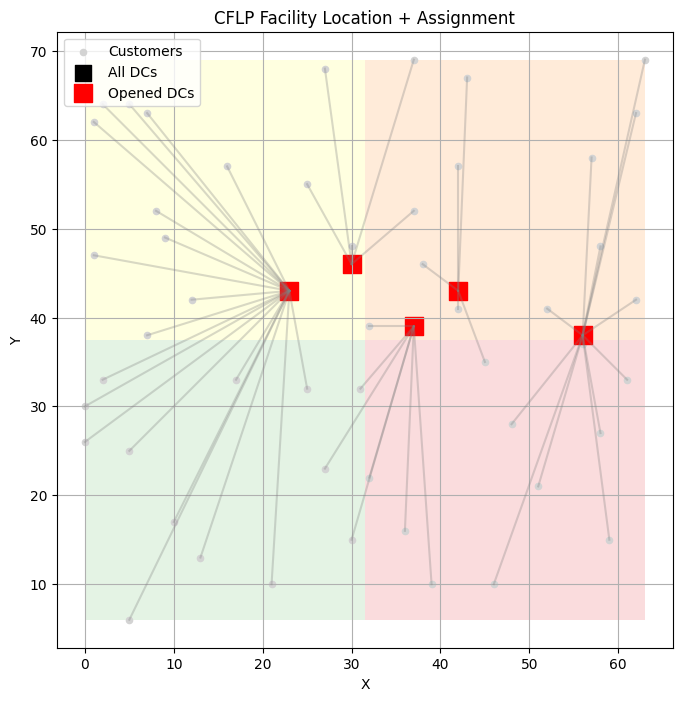

In [38]:
open_dcs_cflp, assign_cflp, cost_cflp = solve_cflp(open_cost_factor=1.0)


Savings VRP total cost: 935.8896424218938


/tmp/ipython-input-59847196.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 20)


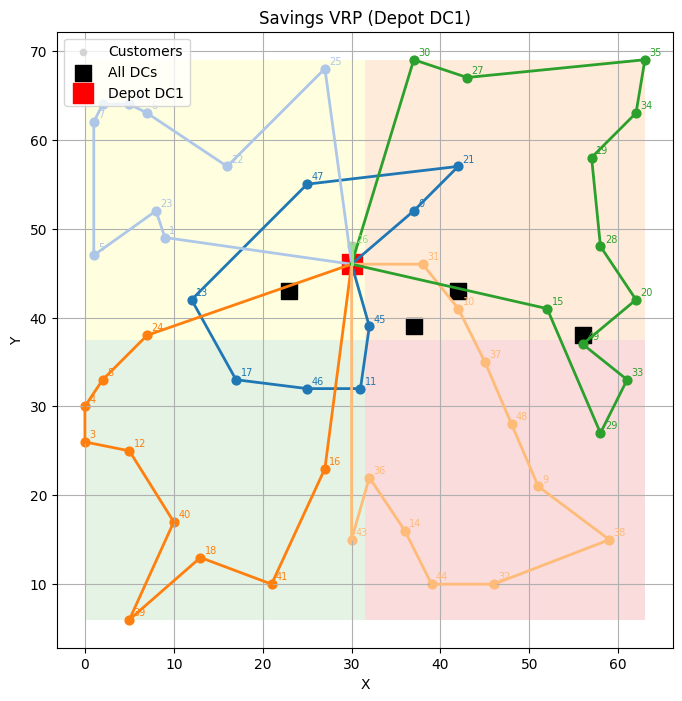

In [39]:
savings_routes = run_savings_and_plot(depot_idx=0, capacity=truck_cap)


GRASP CVRP total cost: 1147.7169431167883


/tmp/ipython-input-59847196.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 20)


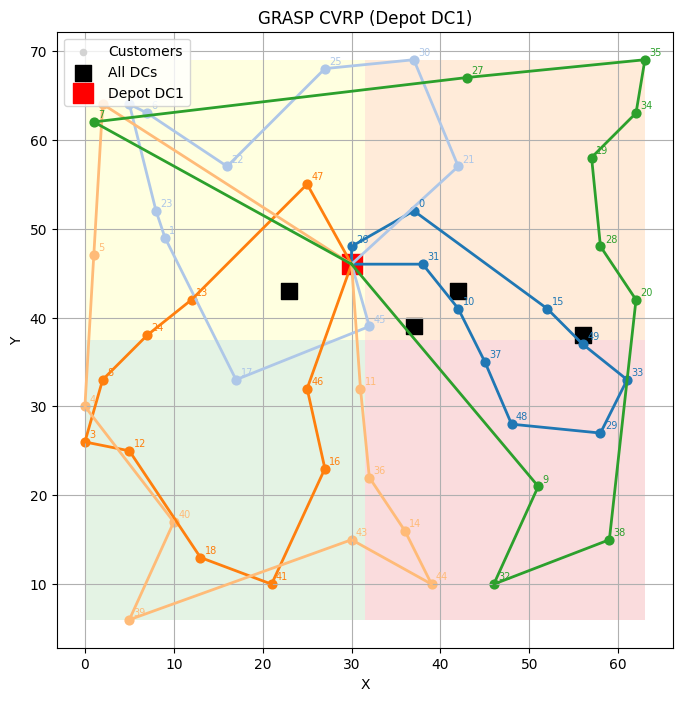

In [40]:
grasp_routes, grasp_cost = run_grasp_and_plot(
    depot_idx=0,
    capacity=truck_cap,
    alpha=0.3,
    max_iters=50,
    seed=42
)


Base (Savings) cost: 935.8896424218938
Local Search (swap) improved cost: 916.6774171470646


/tmp/ipython-input-59847196.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", 20)


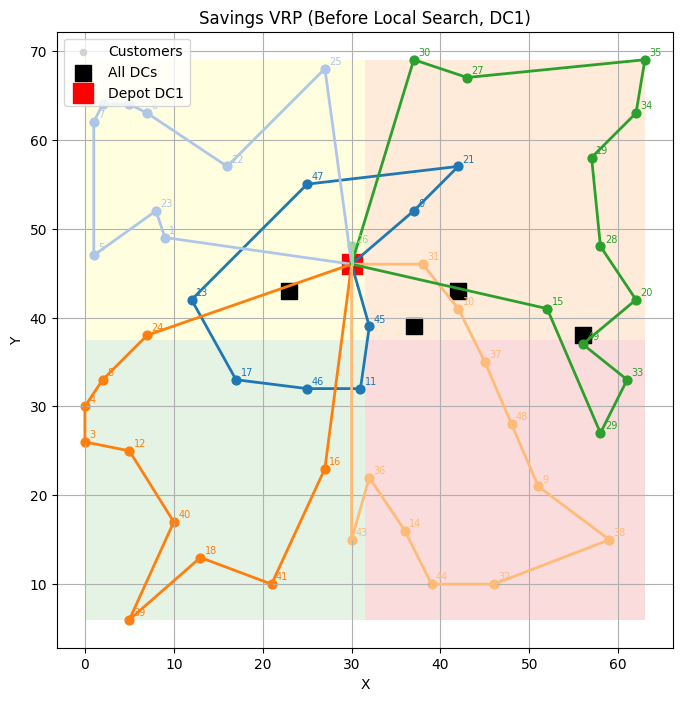

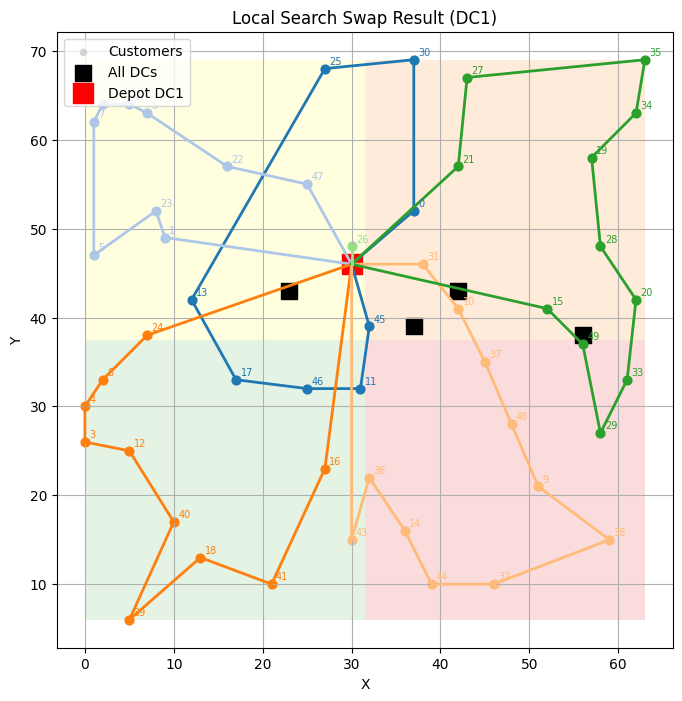

In [41]:
base_r, base_c, ls_r, ls_c = run_local_search_on_savings(
    depot_idx=0,
    capacity=truck_cap
)
